#PREPARATION

In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
%cd "/content/drive/MyDrive/PROA Fake News - 5"
!pwd

/content/drive/.shortcut-targets-by-id/1eCGXpqekvISt1oa3w-VJLwFU75rIezcD/PROA Fake News - 5
/content/drive/.shortcut-targets-by-id/1eCGXpqekvISt1oa3w-VJLwFU75rIezcD/PROA Fake News - 5


In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os, re, csv, math, codecs
import string
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,Input,concatenate,GlobalAveragePooling1D,GlobalMaxPool1D, Activation, GRU,Conv1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras import activations

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics

from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model

# Performance metric
from sklearn.metrics import f1_score , hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import pickle

#DATASET

In [199]:
df_fake = pd.read_csv("dataset/Fake.csv")
df_true = pd.read_csv("dataset/True.csv")

In [200]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [201]:
print("Average Lenght TRUE: ",df_true["text"].apply(len).mean())
print("Max Lenght TRUE: ",df_true["text"].apply(len).max())
print("Min Lenght TRUE: ",df_true["text"].apply(len).min())

Average Lenght TRUE:  2383.278517065882
Max Lenght TRUE:  29781
Min Lenght TRUE:  1


In [202]:
df_true.groupby('subject').count()

,title,text,date
subject,,,
politicsNews,11272,11272,11272
worldnews,10145,10145,10145


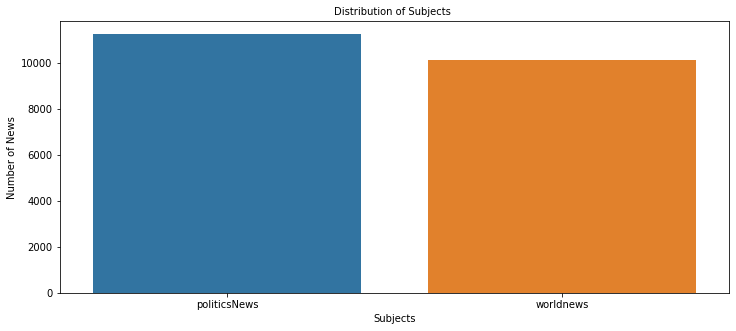

In [203]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="subject", data=df_true)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Subjects ", fontsize = 10)
plt.xlabel("Subjects", fontsize = 10)
plt.ylabel("Number of News", fontsize = 10)
plt.show()

In [204]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [205]:
print("Average Lenght FAKE: ",df_fake["text"].apply(len).mean())
print("Max Lenght FAKE: ",df_fake["text"].apply(len).max())
print("Min Lenght FAKE: ",df_fake["text"].apply(len).min())

Average Lenght FAKE:  2547.396235254035
Max Lenght FAKE:  51794
Min Lenght FAKE:  1


In [206]:
df_fake.groupby('subject').count()

,title,text,date
subject,,,
Government News,1570,1570,1570
Middle-east,778,778,778
News,9050,9050,9050
US_News,783,783,783
left-news,4459,4459,4459
politics,6841,6841,6841


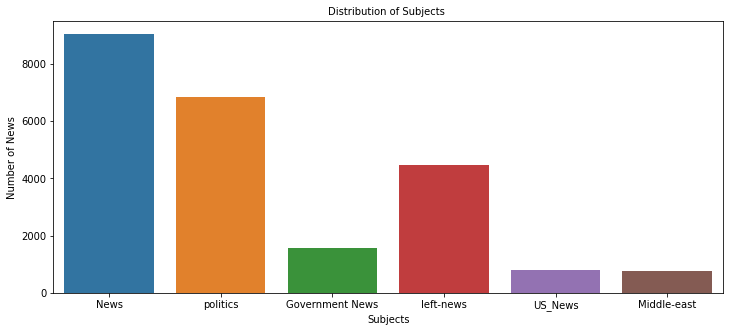

In [207]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="subject", data=df_fake)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Subjects ", fontsize = 10)
plt.xlabel("Subjects", fontsize = 10)
plt.ylabel("Number of News", fontsize = 10)
plt.show()

In [208]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [209]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


ASSIGN CLASS LABEL

In [210]:
df_fake["class"] = 0
df_true["class"] = 1

In [211]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

**ISOT dataset**: In 2017, Ahmed et al. [14] introduced a new dataset that was
collected from real-world sources. This dataset consists of news articles from Reuters.com and Kaggle.com for real news and fake news, respectively. Every instance in the dataset is longer than 200 characters. For each article, the following metadata is available: article type, article text, article title, article date, and article label (fake or real). In this dataset, 44898 article news are contained in total, 21417 of them are real (label class is 1) and 23481 are fake (label class is 0). The dataset features include title, news body, subject, date and
label. There are eight different news topics in column ‘subject’. To get enough information, we combine the news body and news title to train and test our models.

MERGE FAKE NEWS AND TRUE NEWS DATAFRAMES

In [212]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [213]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [214]:
df_merge.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [215]:
df_merge.nunique()

title      38729
text       38646
subject        8
date        2397
class          2
dtype: int64

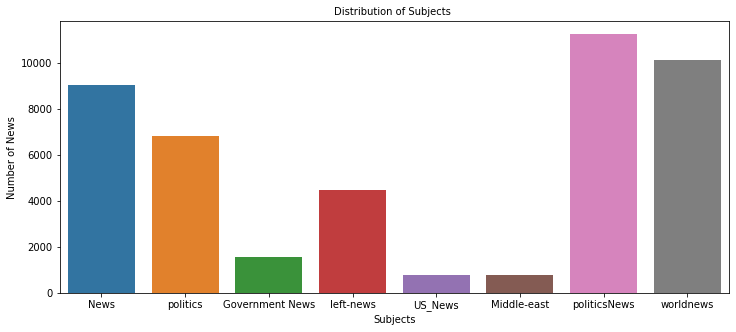

In [216]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="subject", data=df_merge)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Subjects ", fontsize = 10)
plt.xlabel("Subjects", fontsize = 10)
plt.ylabel("Number of News", fontsize = 10)
plt.show()

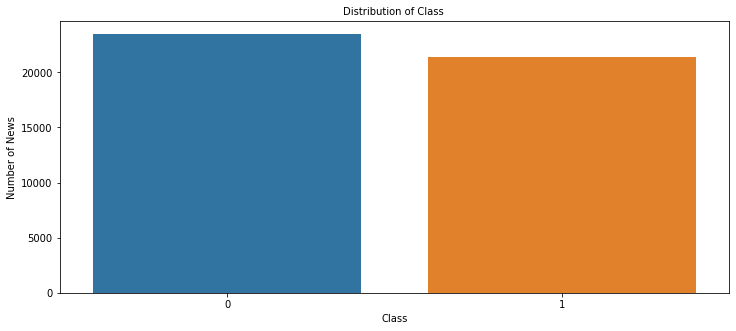

In [217]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="class", data=df_merge)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Class ", fontsize = 10)
plt.xlabel("Class", fontsize = 10)
plt.ylabel("Number of News", fontsize = 10)
plt.show()

In [218]:
df_merge['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [219]:
print("Average Lenght: ",df_merge["text"].apply(len).mean())
print("Max Lenght: ",df_merge["text"].apply(len).max())
print("Min Lenght: ",df_merge["text"].apply(len).min())

Average Lenght:  2469.1096930820972
Max Lenght:  51794
Min Lenght:  1


REMOVING UNNECESSARY COLUMN

In [220]:
df = df_merge.drop(["title", "subject","date"], axis = 1)

In [221]:
df.isnull().sum()

text     0
class    0
dtype: int64

RANDOM SHUFFLING THE DATAFRAME

In [222]:
df = df.sample(frac = 1)

In [223]:
df.head()

,text,class
21775,,0
18561,The latest video of Maxine Waters is downright...,0
5957,"First Lady Michelle Obama, along with an impre...",0
10468,CNN reported that they declined to expose a pr...,0
3397,Donald Trump has long had a contentious relati...,0


In [224]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [225]:
df.columns

Index(['text', 'class'], dtype='object')

In [226]:
df.head()

,text,class
0,,0
1,The latest video of Maxine Waters is downright...,0
2,"First Lady Michelle Obama, along with an impre...",0
3,CNN reported that they declined to expose a pr...,0
4,Donald Trump has long had a contentious relati...,0


In [227]:
df

,text,class
0,,0
1,The latest video of Maxine Waters is downright...,0
2,"First Lady Michelle Obama, along with an impre...",0
3,CNN reported that they declined to expose a pr...,0
4,Donald Trump has long had a contentious relati...,0
...,...,...
44893,"MELBOURNE, Fla. (Reuters) - President Donald T...",1
44894,The prospect of Donald Trump winning the presi...,0
44895,Michael Flynn drove another nail into the coff...,0
44896,Where s George Soros when his top fact check...,0


#PREPROCESSING DATA

In [228]:
# checking duplicate dataset
df.duplicated().sum()
df = df.drop_duplicates()

In [229]:
def preprocess(text):
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [230]:
df["text"] = df["text"].apply(preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [231]:
df.head()

,text,class
0,,0
1,the latest video of maxine waters is downright...,0
2,first lady michelle obama along with an impre...,0
3,cnn reported that they declined to expose a pr...,0
4,donald trump has long had a contentious relati...,0


In [232]:
df.shape

(38647, 2)

MENENTUKAN DEPENDENT DAN INDEPENDENT VARIABEL

In [233]:
X = df["text"]
Y = df["class"]

#TRAIN,VALIDATION,TEST DATA SPLIT

In [234]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [235]:
print (len(x_train))
print (len(x_val))
print (len(x_test))

30917
3865
3865


# Define Performance Measurement

In [236]:
def print_evaluation_scores(y_test, predicted):
    
    # print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('Precision macro: ', precision_score(y_test, predicted, average='macro'))
    print('Recall macro: ', recall_score(y_test, predicted, average='macro'))
    print ("======================================")
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('Precision micro: ', precision_score(y_test, predicted, average='micro'))
    print('Recall micro: ', recall_score(y_test, predicted, average='micro'))
    print ("======================================")
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision weighted: ', precision_score(y_test, predicted, average='weighted'))
    print('Recall weighted: ', recall_score(y_test, predicted, average='weighted'))
    print ("======================================")

    print ("Accuracy score :",accuracy_score(y_test, predicted))
    print("Hamming loss :",hamming_loss(y_test,predicted))

# Tokenize & Padding

In [261]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_ = tokenizer.texts_to_sequences(x_train)
x_val_ = tokenizer.texts_to_sequences(x_val)
x_test_ = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 2000
# maxlen = df_uu.preprocessedArgumen.apply(lambda x: len(x.split())).max()

xtrain = pad_sequences(x_train_, padding='post', maxlen=maxlen)
xval = pad_sequences(x_val_, padding='post', maxlen=maxlen)
xtest = pad_sequences(x_test_, padding='post', maxlen=maxlen)

In [238]:
vocab_size

95568

# **CNN+FASTEXT EMBEDDING MODEL**

## LOAD WORD EMBEDDING (Fasttext)

In [127]:
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

In [128]:
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

1999996it [02:52, 11606.47it/s]


In [129]:
print('Found %s word vectors.' % len(embeddings_index))
# this function creates a normalized vector for the whole sentence

Found 1999996 word vectors.


##MAPPING SETIAP KATA UNIK DENGAN FASTTEXT VEKTOR

In [132]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [133]:
embedding_matrix.shape

(95682, 300)

##BUILD MODEL

In [134]:
embed_size = 300 # how big is each word vector
#maxlen = 400 # max number of words in a comment to use
LEARNING_RATE = 0.001
EPOCHS = 35
BATCH_SIZE = 64

In [135]:
filter_length = 300

model = Sequential()
model.add(Embedding(vocab_size, filter_length,weights=[embedding_matrix], input_length=maxlen))

model.add(Conv1D(filter_length, 2, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalMaxPool1D())
model.add(Dense(1,kernel_initializer='glorot_normal'))
model.add(Activation('sigmoid'))


In [136]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [137]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 300)          28704600  
                                                                 
 conv1d_2 (Conv1D)           (None, 511, 300)          180300    
                                                                 
 dropout_2 (Dropout)         (None, 511, 300)          0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                      

In [138]:
checkpoint = ModelCheckpoint(
    'fakenewsdetection-CNN+fasttext-skenario-AE.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

In [139]:
## Fit train data
history = model.fit(xtrain, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(xval, y_val), callbacks=[checkpoint])

Epoch 1/35
484/484 [==============================] - 15s 29ms/step - loss: 0.0546 - accuracy: 0.9812 - val_loss: 0.0224 - val_accuracy: 0.9940
Epoch 2/35
484/484 [==============================] - 14s 29ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.0183 - val_accuracy: 0.9933
Epoch 3/35
484/484 [==============================] - 13s 27ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0138 - val_accuracy: 0.9956
Epoch 4/35
484/484 [==============================] - 13s 26ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0199 - val_accuracy: 0.9935
Epoch 5/35
484/484 [==============================] - 15s 31ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0134 - val_accuracy: 0.9940
Epoch 6/35
484/484 [==============================] - 12s 26ms/step - loss: 9.9328e-04 - accuracy: 0.9999 - val_loss: 0.0218 - val_accuracy: 0.9917
Epoch 7/35
484/484 [==============================] - 15s 31ms/step - loss: 9.0661e-04 - accuracy: 0.9999 - val_loss: 0.0122 - val_a

## Evaluate Model

In [140]:
loaded_model = load_model('fakenewsdetection-CNN+fasttext-skenario-AE.h5')

121/121 - 1s - loss: 0.0139 - accuracy: 0.9964 - 639ms/epoch - 5ms/step


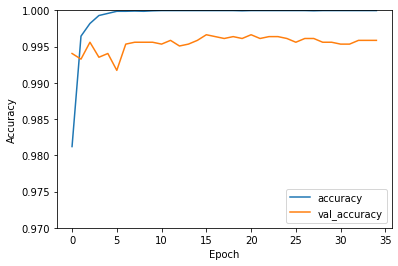

In [141]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.97, 1])
plt.legend(loc='lower right')

test_loss, test_acc = loaded_model.evaluate(xtest,  y_test, verbose=2)

In [142]:
y_pred = loaded_model.predict(xtest)

In [143]:
pred_class = np.where(y_pred > 0.5, 1, 0)

In [144]:
np.unique(pred_class)

array([0, 1])

In [145]:
from sklearn.metrics import classification_report

In [146]:
print(classification_report(y_test, pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1799
           1       1.00      1.00      1.00      2066

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



In [147]:
print_evaluation_scores(y_test, pred_class)

F1-score macro:  0.9963606403013181
Precision macro:  0.9963255232880958
Recall macro:  0.9963962984706465
F1-score micro:  0.9963777490297542
Precision micro:  0.9963777490297542
Recall micro:  0.9963777490297542
F1-score weighted:  0.9963778781522329
Precision weighted:  0.9963785433376121
Recall weighted:  0.9963777490297542
Accuracy score : 0.9963777490297542
Hamming loss : 0.0036222509702457956


# **CNN+GLOVE EMBEDDING MODEL**

##Load Glove Embedding

In [263]:
embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8')

In [264]:
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

2196018it [03:22, 10869.92it/s]


In [265]:
print('Found %s word vectors.' % len(embeddings_index))
# this function creates a normalized vector for the whole sentence

Found 2196016 word vectors.


In [266]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [267]:
embedding_matrix.shape

(95568, 300)

##BUILD MODEL

In [299]:
embed_size = 300 # how big is each word vector
#maxlen = 400 # max number of words in a comment to use
LEARNING_RATE = 0.0001
EPOCHS = 20
BATCH_SIZE = 128

In [300]:
filter_length = 300

model = Sequential()
model.add(Embedding(vocab_size, filter_length,weights=[embedding_matrix], input_length=maxlen))

model.add(Conv1D(filter_length, 2, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalMaxPool1D())
model.add(Dense(1,kernel_initializer='glorot_normal'))
model.add(Activation('sigmoid'))


In [301]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [302]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 2000, 300)         28670400  
                                                                 
 conv1d_9 (Conv1D)           (None, 1999, 300)         180300    
                                                                 
 dropout_9 (Dropout)         (None, 1999, 300)         0         
                                                                 
 global_max_pooling1d_9 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 301       
                                                                 
 activation_9 (Activation)   (None, 1)                 0         
                                                      

In [303]:
checkpoint = ModelCheckpoint(
    'fakenewsdetection-CNN+Glove-skenario-D3.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

In [304]:
## Fit train data
history = model.fit(xtrain, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(xval, y_val), callbacks=[checkpoint])

Epoch 1/20
242/242 [==============================] - 42s 172ms/step - loss: 0.2020 - accuracy: 0.9393 - val_loss: 0.0779 - val_accuracy: 0.9943
Epoch 2/20
242/242 [==============================] - 43s 177ms/step - loss: 0.0284 - accuracy: 0.9942 - val_loss: 0.0305 - val_accuracy: 0.9964
Epoch 3/20
242/242 [==============================] - 43s 176ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0222 - val_accuracy: 0.9972
Epoch 4/20
242/242 [==============================] - 43s 177ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0173 - val_accuracy: 0.9977
Epoch 5/20
242/242 [==============================] - 43s 178ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0158 - val_accuracy: 0.9977
Epoch 6/20
242/242 [==============================] - 43s 177ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0125 - val_accuracy: 0.9979
Epoch 7/20
242/242 [==============================] - 43s 176ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0122 - val_ac

## Evaluate Model


In [305]:
loaded_model = load_model('fakenewsdetection-CNN+Glove-skenario-D3.h5')

121/121 - 1s - loss: 0.0053 - accuracy: 0.9984 - 1s/epoch - 12ms/step


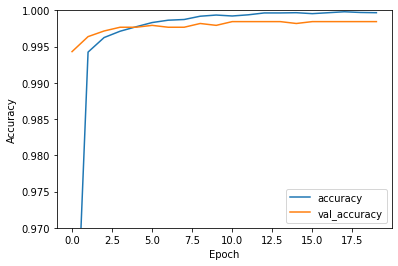

In [306]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.97, 1])
plt.legend(loc='lower right')

test_loss, test_acc = loaded_model.evaluate(xtest,  y_test, verbose=2)

In [307]:
y_pred = loaded_model.predict(xtest)

In [308]:
pred_class = np.where(y_pred > 0.5, 1, 0)

In [309]:
np.unique(pred_class)

array([0, 1])

In [310]:
from sklearn.metrics import classification_report

In [311]:
print(classification_report(y_test, pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1702
           1       1.00      1.00      1.00      2163

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



In [312]:
print_evaluation_scores(y_test, pred_class)

F1-score macro:  0.9984248064121722
Precision macro:  0.9985518672582582
Recall macro:  0.9982999794101525
F1-score micro:  0.9984476067270375
Precision micro:  0.9984476067270375
Recall micro:  0.9984476067270375
F1-score weighted:  0.9984474105952968
Precision weighted:  0.9984493851582736
Recall weighted:  0.9984476067270375
Accuracy score : 0.9984476067270375
Hamming loss : 0.0015523932729624838
